# Emotion Detection Project

Team ID: C241-PS141
* M001D4KX1840 – Cheisha Amanda – Institut Pertanian Bogor
* M012D4KX2134 – Sofi Nurhayati Latifah – Universitas Telkom
* M012D4KX2314 – Nabila Aurellia – Universitas Telkom


# Dataset

In [ ]:
!pip install gdown

In [ ]:
# import requires packages
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Download file from gdrive

In [ ]:
# Define file ID and destination path
file_id = '1RQ-K0GLGR1K8hssE01Px8vWjvXmqqIFD'
destination = '/content/facerecog.zip'

# Download file
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', destination, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1RQ-K0GLGR1K8hssE01Px8vWjvXmqqIFD
To: /content/facerecog.zip
100%|██████████| 12.9M/12.9M [00:00<00:00, 19.1MB/s]


'/content/facerecog.zip'

Extract the zip file

In [ ]:
#define the extraction path
extraction_path = '/content/facerecog'

#Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# List the files in the extraction directory to verify
print(os.listdir(extraction_path))

['EmoSense_Dataset2']


Create a train, valid, and test path

In [ ]:
# Define the path to the EmoSense_Dataset1 directory
images_directory = '/content/facerecog/EmoSense_Dataset2'

# Define paths for train, test, and valid folders
train_path = os.path.join(images_directory, 'train')
test_path = os.path.join(images_directory, 'test')
valid_path = os.path.join(images_directory, 'valid')

# List the contents of the train directory
train_contents = os.listdir(train_path)
print("Contents of train directory:", train_contents)

# List the contents of the valid directory
val_contents = os.listdir(valid_path)
print("Contents of valid directory:", val_contents)

# List the contents of the test directory
test_contents = os.listdir(test_path)
print("Contents of test directory:", test_contents)

Contents of train directory: ['angry', 'sad', 'surprise', 'happy', 'disgust', 'neutral', 'fear']
Contents of valid directory: ['angry', 'sad', 'surprise', 'happy', 'disgust', 'neutral', 'fear']
Contents of test directory: ['angry', 'sad', 'surprise', 'happy', 'disgust', 'neutral', 'fear']


Data Analysis

In [ ]:
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_path, 'train')
print(train_count)

# Count the files in the subdirectories of the validation directory and print the result.
val_count = count_files_in_subdirs(valid_path, 'validation')
print(val_count)

# Count the files in the subdirectories of the validation directory and print the result.
test_count = count_files_in_subdirs(test_path, 'test')
print(test_count)

       angry  sad  surprise  happy  disgust  neutral  fear
train     70   70        70     70       70       70    70
            angry  sad  surprise  happy  disgust  neutral  fear
validation     20   20        20     20       20       20    20
      angry  sad  surprise  happy  disgust  neutral  fear
test     10   10        10     10       10       10    10


# Image Processsing

## Data Augmentation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from ipywidgets import FileUpload
from IPython.display import display
import io
from keras.optimizers import Adam

In [ ]:
def train_val_generators(train_path, valid_path, test_path):
    # Define the ImageDataGenerator for augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Define ImageDataGenerator for validation and testing
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    test_datagen = ImageDataGenerator(rescale=1./255.)

    # Flow training images in batches of 16 using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(640, 640),  # Maintain the original image size
        batch_size=16,
        shuffle=True,
        color_mode='rgb',
        class_mode='categorical')

    # Flow validation images in batches of 16 using validation_datagen generator
    validation_generator = validation_datagen.flow_from_directory(
        valid_path,
        target_size=(640, 640),  # Maintain the original image size
        batch_size=16,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False)

    # Flow test images in batches of 16 using test_datagen generator
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(640, 640),  # Maintain the original image size
        batch_size=16,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False)

    return train_generator, validation_generator, test_generator

# Instantiate generators
train_generator, validation_generator, test_generator = train_val_generators(train_path, valid_path, test_path)

Found 490 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


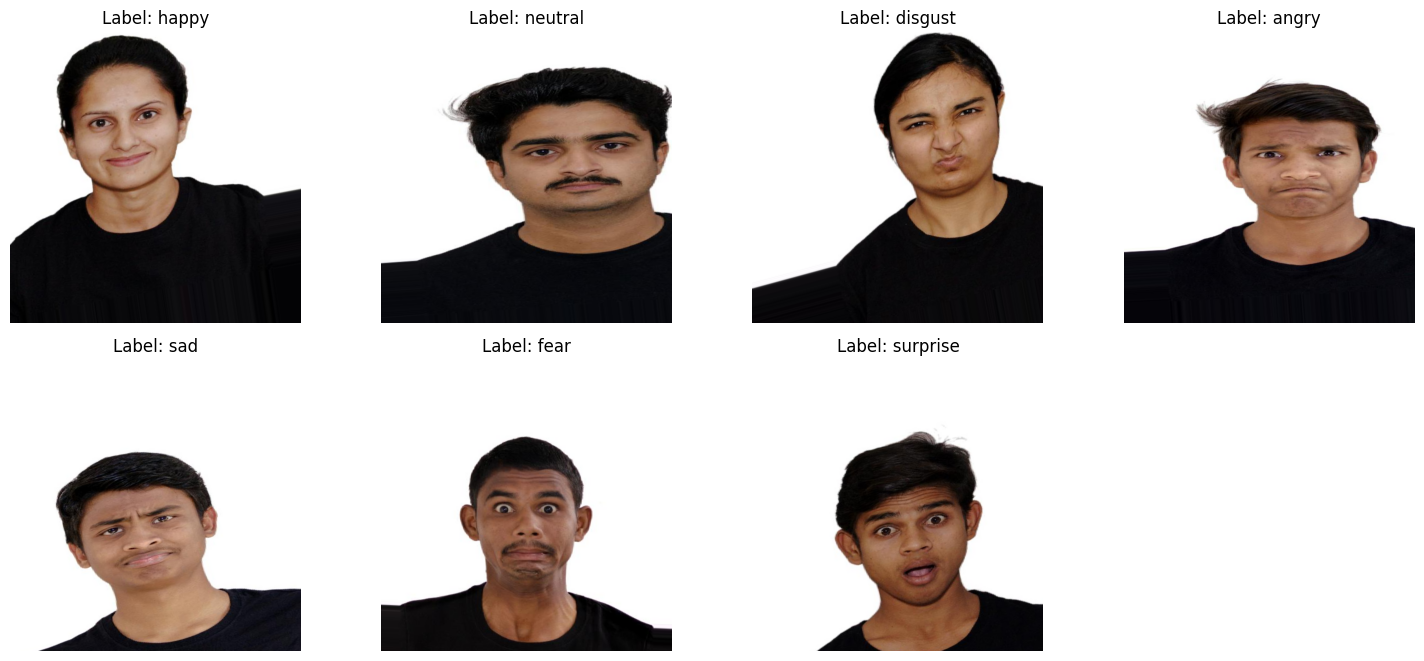

In [ ]:
# Obtain a batch of images from the train generator
x_batch, y_batch = next(train_generator)

# Display only one image per class
plt.figure(figsize=(15, 10))
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
num_classes = len(class_labels)

# Initialize variables to keep track of displayed classes
classes_displayed = set()

# Loop over the batch and display one image per class
for i in range(len(x_batch)):
    label_index = np.argmax(y_batch[i])
    class_label = class_labels[label_index]

    # Display only one image per class
    if class_label not in classes_displayed:
        plt.subplot(3, 4, len(classes_displayed) + 1)  # Adjusted to 3x3 grid to fit all classes
        plt.imshow(x_batch[i])
        plt.title(f"Label: {class_label}")
        plt.axis('off')
        classes_displayed.add(class_label)

    # Stop once one image per class is displayed
    if len(classes_displayed) == num_classes:
        break

plt.tight_layout()
plt.show()

In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the test data
test_class_labels = test_generator.class_indices
print("Test class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Create Model

In [ ]:
def new_model():
    # Input layer with batch_input_shape
    inputs = Input(shape=(640, 640, 3))

    # Base model with VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Make all layers in the base model trainable
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = new_model()


In [ ]:
# Build the model by calling it with a sample input
model.build(input_shape=(None, 640, 640, 3))

In [ ]:
# Print the model summary
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 640, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 320, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 160, 160, 128)     0  

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [ ]:
model = new_model()

# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es, mc, lr_scheduler]
                    )

Epoch 1/50
31/31 [==============================] - 88s 3s/step - loss: 2.9237 - accuracy: 0.3082 - val_loss: 2.6769 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 2/50
31/31 [==============================] - 82s 3s/step - loss: 2.2825 - accuracy: 0.4776 - val_loss: 2.6083 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 3/50
31/31 [==============================] - 81s 3s/step - loss: 1.9576 - accuracy: 0.5571 - val_loss: 2.6947 - val_accuracy: 0.1929 - lr: 1.0000e-04
Epoch 4/50
31/31 [==============================] - 82s 3s/step - loss: 1.5716 - accuracy: 0.7122 - val_loss: 2.2256 - val_accuracy: 0.5214 - lr: 1.0000e-04
Epoch 5/50
31/31 [==============================] - 80s 3s/step - loss: 1.2976 - accuracy: 0.7755 - val_loss: 2.0602 - val_accuracy: 0.5643 - lr: 1.0000e-04
Epoch 6/50
31/31 [==============================] - 80s 3s/step - loss: 1.1833 - accuracy: 0.8286 - val_loss: 1.9302 - val_accuracy: 0.6286 - lr: 1.0000e-04
Epoch 7/50
31/31 [==============================] - 81s 3s

Evaluating Accuracy and Loss for the Model

Text(0.5, 1.0, 'Training and validation loss')

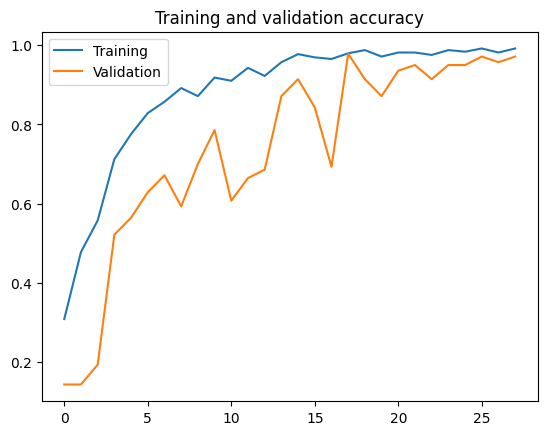

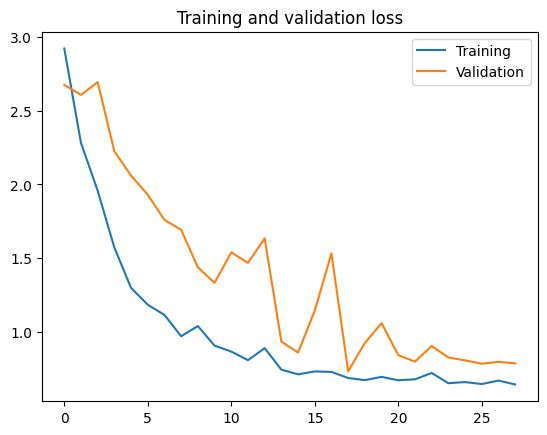

In [ ]:
#sets for each training epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs
epochs = range(len(accuracy))

#plot training and validation accuracy per epoch
plt.plot  ( epochs,     accuracy, label='Training')
plt.plot  ( epochs, val_accuracy, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#plot training and validation loss per epoch
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [ ]:
# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)

# Print hasil evaluasi
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


5/5 [==============================] - 12s 3s/step - loss: 0.6804 - accuracy: 0.9857
Loss: 0.6804
Accuracy: 0.9857


# Save Model

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
     

In [ ]:
saved_model_path = "./emosense_model.h5"
model.save(saved_model_path)

# Convert to TFjs

In [ ]:
import tensorflow as tf
import os
import shutil
from IPython.display import FileLink

# Convert the model to TensorFlow.js format
!tensorflowjs_converter \
  --input_format=keras \
  {saved_model_path} \
  "./model"

# Verify the converted model files
converted_files = os.listdir('./model')
print("Converted files:", converted_files)

# Zip the converted model files for download
shutil.make_archive('model', 'zip', './model')

# Create a link to download the zip file
FileLink(r'model.zip')

2024-06-19 06:50:18.194398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Converted files: ['group1-shard5of15.bin', 'group1-shard2of15.bin', 'group1-shard8of15.bin', 'group1-shard1of15.bin', 'group1-shard11of15.bin', 'group1-shard3of15.bin', 'group1-shard6of15.bin', 'group1-shard4of15.bin', 'group1-shard12of15.bin', 'group1-shard14of15.bin', 'model.json', 'group1-shard15of15.bin', 'group1-shard9of15.bin', 'group1-shard10of15.bin', 'group1-shard13of15.bin', 'group1-shard7of15.bin']


/content/model.zip